## Exercise 5.8: Racetrack (programming) 
Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. 
* The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. 
* The actions are increments to the velocity components. Each may be changed by +1, −1, or 0 in one step, for a total of nine actions. 
* Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. 
* Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. 
* The rewards are −1 for each step until the car crosses the finish line. 
* If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. 
* Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. 
* To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. 

Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

<img src="racetrack.png" width="600">

In [140]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

CELL_TYPE_WALL = 0
CELL_TYPE_TRACK = 1
CELL_TYPE_GOAL = 2
CELL_TYPE_START = 3

class RaceTrack:
    def __init__(self, track, min_vel=0, max_vel=5):
        self.track = track
        self.wall_cells = np.argwhere(track == CELL_TYPE_WALL).tolist()
        self.goal_cells = np.argwhere(track == CELL_TYPE_GOAL).tolist()
        self.start_cells = np.argwhere(track == CELL_TYPE_START).tolist()
        self.min_vel = min_vel
        self.max_vel = max_vel
    
    @classmethod
    def from_csv(cls, file_path):
        
        file_path = os.path.join(os.getcwd(), file_path)
        
        track = genfromtxt(file_path, delimiter=',')
        
        # Flip the y-axis coordinates
        track = np.flip(track, axis=0)

        return cls(track) 
    
    def possible_actions(self, state):
        actions = [[a_y, a_x] for a_y in range(-1, 2) for a_x in range(-1, 2)]
        legal_actions = []

        _, _, v_y, v_x = state

        # Discard illegal actions
        for a in actions:
            a_y, a_x = a
            # Cannot go above speed limit in any x direction
            if v_x + a_x < self.min_vel or v_x + a_x > self.max_vel:
                continue
            # Cannot go above speed limit in any y direction
            if v_y + a_y < self.min_vel or v_y + a_y > self.max_vel:
                continue
            # Cannot noop
            if v_x + a_x == 0 and v_y + a_y == 0:
                continue
            legal_actions.append(a)
        return legal_actions
    
    def random_start_state(self):
        start_cell_idx = np.random.choice(len(self.start_cells))
        start_state = np.array(self.start_cells[start_cell_idx] + [0, 0])
        return start_state
    
    def apply_action(self, state, action):
        y_coord, x_coord, y_vel, x_vel = state
        a_y, a_x = action

        next_y_vel = y_vel + a_y
        next_x_vel = x_vel + a_x
        next_y_coord = y_coord + next_y_vel
        next_x_coord = x_coord + next_x_vel

        path = self.projected_path(
            (y_coord, x_coord), (next_y_vel, next_x_vel))

        #if self.crossed_finish_line(path):
        if self.crossed_finish_line([[next_y_coord, next_x_coord]]):
            return np.array([next_y_coord, next_x_coord, next_y_vel, next_x_vel]), 0, True
        #if self.crossed_track_boundary(path):
        if self.crossed_track_boundary([[next_y_coord, next_x_coord]]):
            return self.random_start_state(), -1, False

        return np.array([next_y_coord, next_x_coord, next_y_vel, next_x_vel]), -1, False
        
    def projected_path(self, state, speed):
        # TODO: Should we only consider end state directly?
        y_coord, x_coord = state
        y_vel, x_vel = speed

        new_y_coord = y_coord + y_vel
        new_x_coord = x_coord + x_vel

        path = []
        for dy in range(min(y_coord, new_y_coord), max(y_coord, new_y_coord) + 1):
            for dx in range(min(x_coord, new_x_coord), max(x_coord, new_x_coord) + 1):
                path.append([dy, dx])
        return path
        
    def crossed_track_boundary(self, projected_path):
        for cell in projected_path:
            y, x = cell
            if y < 0 or y >= self.track.shape[0] or x < 0 or x >= self.track.shape[1] or cell in self.wall_cells:
                return True
        return False

    def crossed_finish_line(self, projected_path):
        for cell in projected_path:
            if cell in self.goal_cells:
                return True
        return False
        
    def draw_episode(self, S, A, R): 
        colors = ['black', 'white', 'yellow', 'red']
        
        print(S)
        
        y_t = [s[1] for s in S]
        x_t = [s[0] for s in S]
        
        plt.figure(figsize=(10,10))
        plt.imshow(self.track, cmap=ListedColormap(colors), origin='lower',interpolation='none')
        
        def rect(pos, edgecolor='k', facecolor='none'):
            r = plt.Rectangle(pos, 1, 1, facecolor=facecolor,
                              edgecolor=edgecolor, linewidth=2)
            plt.gca().add_patch(r)

        for i in range(self.track.shape[0]):
            for j in range(self.track.shape[1]):
                rect((j-0.5, i-0.5))
        
        plt.plot(np.asarray(y_t), np.asarray(x_t),'o-')
        #plt.scatter(y_t[-1], x_t[-1], color='red', s=50)
        
#         fig=plt.figure(figsize=(10,10))
#         im = plt.imshow(self.track, cmap=ListedColormap(colors),
#                         origin='lower', interpolation='none')
        
#         def init():
#             im.set_data(self.track)
#             return [im]
            
#         def animate(i):
#             a = im.get_array()
            
        
        

        

#         

#         if path:
#             for cell in path:
#                 rect((cell[1]-0.5, cell[0]-0.5), edgecolor='g')

#         if car_cell:
#             rect((car_cell[1]-0.5, car_cell[0]-0.5),
#                  edgecolor='g', facecolor='g')

        plt.gca().invert_yaxis()
        #return im
        

In [141]:
rt = RaceTrack.from_csv("../racetracks/map1.csv")

In [142]:
path = rt.projected_path((6,8),(-2,2))
path

[[4, 8], [4, 9], [4, 10], [5, 8], [5, 9], [5, 10], [6, 8], [6, 9], [6, 10]]

In [143]:
import random
import math
from collections import defaultdict

class OnPolicyMonteCarloAgent:
    def __init__(self, track, gamma=0.25, n_episodes=100000, eps=0.9):
        self.track = track
        self.gamma = gamma
        self.n_episodes = n_episodes
        self.eps = eps

        # Initialize Q values and C values
        y_range = track.track.shape[0]
        x_range = track.track.shape[1]
        yvel_range = track.max_vel - track.min_vel + 1
        xvel_range = track.max_vel - track.min_vel + 1
        yacc_range = 3  # -1, 0, +1
        xacc_range = 3  # -1, 0, +1

        # Initialize state-action values
        self.Q = np.zeros((y_range, x_range, yvel_range,
                           xvel_range, yacc_range, xacc_range))

        # Initialize rewards dictionary
        self.R = defaultdict(list)

        # Initial Policy
        # For each state: assign equal probability of selecting each valid action from the state
        self.pi = np.zeros(self.Q.shape, dtype=float)
        for y_coord in range(self.Q.shape[0]):
            for x_coord in range(self.Q.shape[1]):
                for y_vel in range(track.min_vel, track.max_vel + 1):
                    for x_vel in range(track.min_vel, track.max_vel + 1):
                        valid_actions = self.track.possible_actions(
                            (y_coord, x_coord, y_vel, x_vel))
                        for y_acc, x_acc in valid_actions:
                            self.pi[y_coord, x_coord, y_vel, x_vel,
                                    y_acc, x_acc] = 1/len(valid_actions)
                        
    def sample_random_action(self, state):
        # Sample action according to our eps-greedy policy
        # Ensure that probabilities we sample from sum to 1
        y_coord, x_coord, y_vel, x_vel = state

        actionprobs = self.pi[y_coord, x_coord, y_vel, x_vel]
        total_prob = np.sum(actionprobs)
        if not math.isclose(total_prob, 1, abs_tol=0.01):
            print(
                'Action probabilities must sum to 1.0, but summed to {}, state: {}, actionprobs: {}'.format(total_prob, state, self.pi[tuple(state)]))
            sys.exit(1)

        linear_idx = np.random.choice(
            actionprobs.size, p=actionprobs.ravel())
        a = np.unravel_index(linear_idx, actionprobs.shape)
        # In case the value is greater than the max allowed action we need to translate it back into
        # negative coordinates
        a = tuple(acc if acc <= 1 else 1 - acc for acc in a)
        return a
    
    def greedy_action(self, state):
        # Find greedy action according to state-action values Q
        Q_state = self.Q[tuple(state)].copy()
        if not (Q_state == 0).all():
            Q_state[Q_state == 0] = np.nan
        a = np.unravel_index(np.nanargmax(Q_state, axis=None), Q_state.shape)
        # In case the value is greater than the max allowed action we need to translate it back into
        # negative coordinates
        a = tuple(acc if acc <= 1 else 1 - acc for acc in a)
        return a
            
    def generate_episode(self, pi, policy_type="eps_greedy"):
        S = []
        A = []
        R = []

        # Select the initial state randomly
        start_state = self.track.random_start_state()
        S.append(start_state)

        terminated = False
        t = 0
        while not terminated:
            St = S[t]

            if t % 10000 == 0:
                print("Step: {}".format(t))
            
            if policy_type == "eps_greedy":
                a = self.sample_random_action(St)
            elif policy_type == "greedy":
                a = self.greedy_action(St)
            else:
                print("Unknown policy_type {} in generate_episode. Must be either `greedy` or `eps_greedy`")
                sys.exit(1)
            A.append(a)

            next_state, reward, terminated = self.track.apply_action(St, a)

            R.append(reward)
            S.append(next_state)
            t += 1

            # time.sleep(1)
        print("Terminated after {} steps".format(t))
        return S, A, R
    
    def policy_iteration(self):
        policy_stable = False
        it = 0
        while True:
            if self.n_episodes is not None and it > self.n_episodes:
                break
            elif self.n_episodes is None and policy_stable:
                break
            
            print('Iteration {}'.format(it))

            # (a) Generate an episode using pi
            S, A, R = self.generate_episode(self.pi)

            visited = set()

            # (b) Iterate over s,a pairs and update rewards and q-values
            old_Q = self.Q.copy()
            for t in range(len(S)-2):
                St, At, Rt = S[t], A[t], R[t]

                state_action_key = tuple(St.tolist() + list(At))

                # Skip to next step if we have aldready encountered this state, action pair
                if state_action_key in visited:
                    continue

                visited.add(state_action_key)

                # Calculate return that follows the first occurence of St, At
                G = 0
                for dt in range(len(S)-2, t-1, -1):
                    G = self.gamma * G + R[dt]

                self.R[state_action_key].append(G)
                self.Q[state_action_key] = np.average(self.R[state_action_key])

            # Q-diff: Credit to Joakim Blach Andersen
            Q_diff = abs(old_Q - self.Q)
            print('Q-diff: {}'.format(np.max(Q_diff)))

            # (c) Iterate over all states s and update the eps-greedy policy
            for t in range(len(S)-2):
                y, x, y_vel, x_vel = S[t]

                possible_actions = self.track.possible_actions(S[t])
                for a in possible_actions:
                    a_y, a_x = a

                    self.pi[y, x, y_vel, x_vel, a_y, a_x] = self.eps / \
                        len(possible_actions)

                # Get index of best action
                a_ys, a_xs = tuple(zip(*possible_actions))
                actionvals = self.Q[y, x, y_vel,
                                    x_vel, a_ys, a_xs]
                a_max_idx = np.argmax(actionvals)
                a_max_y, a_max_x = a_ys[a_max_idx], a_xs[a_max_idx]

                self.pi[y, x, y_vel, x_vel, a_max_y, a_max_x] += 1 - self.eps

                actionprobs = self.pi[y, x, y_vel, x_vel]
                total_prob = np.sum(actionprobs)
                if not math.isclose(total_prob, 1, abs_tol=0.01):
                    print(
                        'Action probabilities must sum to 1.0, but summed to {}, state: {}, actionprobs: {}'.format(total_prob, s, self.pi[y, x, y_vel, x_vel]))
                    sys.exit(1)
            
            # Check if convergence in case no number of episodes is set to 0
            if np.allclose(old_Q, self.Q, atol=0.05):
                print("Policy iteration converged after {} episodes".format(it))
                policy_stable = True

            # Counter and update epsilon
            self.eps = 1/(math.sqrt(it+1.1))
            it += 1

In [144]:
agent = OnPolicyMonteCarloAgent(rt, n_episodes=1000, eps=0.5, gamma=0.80)

In [145]:
agent.policy_iteration()

Iteration 0
Step: 0
Step: 10000
Terminated after 19310 steps
Q-diff: 4.999999999999998
Iteration 1
Step: 0
Terminated after 5509 steps
Q-diff: 4.999999999999998
Iteration 2
Step: 0
Terminated after 696 steps
Q-diff: 4.999999999999998
Iteration 3
Step: 0
Terminated after 371 steps
Q-diff: 4.999999999999998
Iteration 4
Step: 0
Step: 10000
Terminated after 12345 steps
Q-diff: 4.999999999999998
Iteration 5
Step: 0
Step: 10000
Terminated after 11973 steps
Q-diff: 4.999999999999998
Iteration 6
Step: 0
Step: 10000
Terminated after 13953 steps
Q-diff: 4.999999999999998
Iteration 7
Step: 0
Step: 10000
Terminated after 12327 steps
Q-diff: 4.999999999999998
Iteration 8
Step: 0
Terminated after 4761 steps
Q-diff: 4.999999999999998
Iteration 9
Step: 0
Step: 10000
Terminated after 11916 steps
Q-diff: 4.999999999999998
Iteration 10
Step: 0
Terminated after 4177 steps
Q-diff: 4.999999999999998
Iteration 11
Step: 0
Terminated after 1780 steps
Q-diff: 4.999999999999998
Iteration 12
Step: 0
Terminated af

Policy iteration converged after 105 episodes
Iteration 106
Step: 0
Terminated after 44 steps
Q-diff: 4.9631065118525814
Iteration 107
Step: 0
Terminated after 14 steps
Q-diff: 0.016988008023767875
Policy iteration converged after 107 episodes
Iteration 108
Step: 0
Terminated after 72 steps
Q-diff: 1.8
Iteration 109
Step: 0
Terminated after 12 steps
Q-diff: 0.016431024154135887
Policy iteration converged after 109 episodes
Iteration 110
Step: 0
Terminated after 28 steps
Q-diff: 4.725122093056001
Iteration 111
Step: 0
Terminated after 98 steps
Q-diff: 4.999985034223235
Iteration 112
Step: 0
Terminated after 106 steps
Q-diff: 0.6618628270641382
Iteration 113
Step: 0
Terminated after 110 steps
Q-diff: 0.015042050695470266
Policy iteration converged after 113 episodes
Iteration 114
Step: 0
Terminated after 25 steps
Q-diff: 1.8
Iteration 115
Step: 0
Terminated after 15 steps
Q-diff: 0.014352249045253895
Policy iteration converged after 115 episodes
Iteration 116
Step: 0
Terminated after 32 

Policy iteration converged after 201 episodes
Iteration 202
Step: 0
Terminated after 105 steps
Q-diff: 4.998377407231709
Iteration 203
Step: 0
Terminated after 42 steps
Q-diff: 0.03435973836799988
Policy iteration converged after 203 episodes
Iteration 204
Step: 0
Terminated after 16 steps
Q-diff: 2.9520000000000004
Iteration 205
Step: 0
Terminated after 51 steps
Q-diff: 4.824078139555841
Iteration 206
Step: 0
Terminated after 39 steps
Q-diff: 0.00352850647102132
Policy iteration converged after 206 episodes
Iteration 207
Step: 0
Terminated after 63 steps
Q-diff: 4.987910741803855
Iteration 208
Step: 0
Terminated after 20 steps
Q-diff: 0.004694222767054335
Policy iteration converged after 208 episodes
Iteration 209
Step: 0
Terminated after 13 steps
Q-diff: 0.0045540967143073985
Policy iteration converged after 209 episodes
Iteration 210
Step: 0
Terminated after 15 steps
Q-diff: 0.0034342143915342405
Policy iteration converged after 210 episodes
Iteration 211
Step: 0
Terminated after 12

Terminated after 21 steps
Q-diff: 0.0020558453555192813
Policy iteration converged after 285 episodes
Iteration 286
Step: 0
Terminated after 19 steps
Q-diff: 0.002018803096860644
Policy iteration converged after 286 episodes
Iteration 287
Step: 0
Terminated after 15 steps
Q-diff: 0.0019827530415588157
Policy iteration converged after 287 episodes
Iteration 288
Step: 0
Terminated after 24 steps
Q-diff: 0.02504443150741764
Policy iteration converged after 288 episodes
Iteration 289
Step: 0
Terminated after 12 steps
Q-diff: 0.0017390237691787824
Policy iteration converged after 289 episodes
Iteration 290
Step: 0
Terminated after 15 steps
Q-diff: 0.0019380913329909433
Policy iteration converged after 290 episodes
Iteration 291
Step: 0
Terminated after 13 steps
Q-diff: 0.0019043853967648516
Policy iteration converged after 291 episodes
Iteration 292
Step: 0
Terminated after 30 steps
Q-diff: 0.020591242717297398
Policy iteration converged after 292 episodes
Iteration 293
Step: 0
Terminated a

Terminated after 16 steps
Q-diff: 0.10666561814026343
Iteration 388
Step: 0
Terminated after 15 steps
Q-diff: 0.0014885955535417494
Policy iteration converged after 388 episodes
Iteration 389
Step: 0
Terminated after 37 steps
Q-diff: 4.984888427254818
Iteration 390
Step: 0
Terminated after 15 steps
Q-diff: 0.001075382972375749
Policy iteration converged after 390 episodes
Iteration 391
Step: 0
Terminated after 16 steps
Q-diff: 0.0010902807321926389
Policy iteration converged after 391 episodes
Iteration 392
Step: 0
Terminated after 49 steps
Q-diff: 0.02917956338334271
Policy iteration converged after 392 episodes
Iteration 393
Step: 0
Terminated after 34 steps
Q-diff: 4.887410009315738
Iteration 394
Step: 0
Terminated after 22 steps
Q-diff: 0.01789307987847888
Policy iteration converged after 394 episodes
Iteration 395
Step: 0
Terminated after 13 steps
Q-diff: 0.09411672188846865
Iteration 396
Step: 0
Terminated after 25 steps
Q-diff: 0.02607634439459172
Policy iteration converged afte

Policy iteration converged after 494 episodes
Iteration 495
Step: 0
Terminated after 12 steps
Q-diff: 0.0006566344217073805
Policy iteration converged after 495 episodes
Iteration 496
Step: 0
Terminated after 21 steps
Q-diff: 0.0018929514197090214
Policy iteration converged after 496 episodes
Iteration 497
Step: 0
Terminated after 14 steps
Q-diff: 0.0008667054012576614
Policy iteration converged after 497 episodes
Iteration 498
Step: 0
Terminated after 29 steps
Q-diff: 0.00632521365456995
Policy iteration converged after 498 episodes
Iteration 499
Step: 0
Terminated after 14 steps
Q-diff: 0.012646783650745341
Policy iteration converged after 499 episodes
Iteration 500
Step: 0
Terminated after 12 steps
Q-diff: 0.0006416773888191507
Policy iteration converged after 500 episodes
Iteration 501
Step: 0
Terminated after 38 steps
Q-diff: 4.981110534068522
Iteration 502
Step: 0
Terminated after 20 steps
Q-diff: 0.0006906195620777211
Policy iteration converged after 502 episodes
Iteration 503
S

Q-diff: 0.059914910650341824
Iteration 590
Step: 0
Terminated after 36 steps
Q-diff: 4.981110534068522
Iteration 591
Step: 0
Terminated after 17 steps
Q-diff: 0.010254746447583507
Policy iteration converged after 591 episodes
Iteration 592
Step: 0
Terminated after 15 steps
Q-diff: 0.0006388270294070963
Policy iteration converged after 592 episodes
Iteration 593
Step: 0
Terminated after 13 steps
Q-diff: 0.0005085755125486813
Policy iteration converged after 593 episodes
Iteration 594
Step: 0
Terminated after 19 steps
Q-diff: 1.0
Iteration 595
Step: 0
Terminated after 12 steps
Q-diff: 0.0005156307531581916
Policy iteration converged after 595 episodes
Iteration 596
Step: 0
Terminated after 15 steps
Q-diff: 0.0005037875711222384
Policy iteration converged after 596 episodes
Iteration 597
Step: 0
Terminated after 37 steps
Q-diff: 0.039047322941084595
Policy iteration converged after 597 episodes
Iteration 598
Step: 0
Terminated after 12 steps
Q-diff: 0.0005129451763190573
Policy iteration 

Policy iteration converged after 677 episodes
Iteration 678
Step: 0
Terminated after 24 steps
Q-diff: 1.8
Iteration 679
Step: 0
Terminated after 12 steps
Q-diff: 0.00045564769463712906
Policy iteration converged after 679 episodes
Iteration 680
Step: 0
Terminated after 31 steps
Q-diff: 4.780097674444801
Iteration 681
Step: 0
Terminated after 26 steps
Q-diff: 0.011453542149818752
Policy iteration converged after 681 episodes
Iteration 682
Step: 0
Terminated after 12 steps
Q-diff: 0.003522154255530374
Policy iteration converged after 682 episodes
Iteration 683
Step: 0
Terminated after 12 steps
Q-diff: 0.003432985793365262
Policy iteration converged after 683 episodes
Iteration 684
Step: 0
Terminated after 15 steps
Q-diff: 0.003347161148532507
Policy iteration converged after 684 episodes
Iteration 685
Step: 0
Terminated after 12 steps
Q-diff: 0.003264515194246087
Policy iteration converged after 685 episodes
Iteration 686
Step: 0
Terminated after 33 steps
Q-diff: 0.004253595848874525
Pol

Terminated after 29 steps
Q-diff: 4.780097674444801
Iteration 784
Step: 0
Terminated after 74 steps
Q-diff: 4.999782219285171
Iteration 785
Step: 0
Terminated after 13 steps
Q-diff: 0.0007456953705018421
Policy iteration converged after 785 episodes
Iteration 786
Step: 0
Terminated after 14 steps
Q-diff: 0.0007150736323948692
Policy iteration converged after 786 episodes
Iteration 787
Step: 0
Terminated after 13 steps
Q-diff: 1.0
Iteration 788
Step: 0
Terminated after 14 steps
Q-diff: 0.0005296619321129015
Policy iteration converged after 788 episodes
Iteration 789
Step: 0
Terminated after 24 steps
Q-diff: 0.0018471692260781936
Policy iteration converged after 789 episodes
Iteration 790
Step: 0
Terminated after 24 steps
Q-diff: 0.007974973421038811
Policy iteration converged after 790 episodes
Iteration 791
Step: 0
Terminated after 16 steps
Q-diff: 0.0005027634267245062
Policy iteration converged after 791 episodes
Iteration 792
Step: 0
Terminated after 13 steps
Q-diff: 1.0
Iteration 7

Q-diff: 0.0013545369195409052
Policy iteration converged after 880 episodes
Iteration 881
Step: 0
Terminated after 16 steps
Q-diff: 0.000440809492120664
Policy iteration converged after 881 episodes
Iteration 882
Step: 0
Terminated after 17 steps
Q-diff: 0.00133635521592268
Policy iteration converged after 882 episodes
Iteration 883
Step: 0
Terminated after 12 steps
Q-diff: 0.0003493168380570566
Policy iteration converged after 883 episodes
Iteration 884
Step: 0
Terminated after 15 steps
Q-diff: 0.0013185371463775297
Policy iteration converged after 884 episodes
Iteration 885
Step: 0
Terminated after 24 steps
Q-diff: 0.01228210364121285
Policy iteration converged after 885 episodes
Iteration 886
Step: 0
Terminated after 14 steps
Q-diff: 0.00046838431081308585
Policy iteration converged after 886 episodes
Iteration 887
Step: 0
Terminated after 14 steps
Q-diff: 0.0012839536956068542
Policy iteration converged after 887 episodes
Iteration 888
Step: 0
Terminated after 12 steps
Q-diff: 0.00

Q-diff: 0.00039523784161854536
Policy iteration converged after 951 episodes
Iteration 952
Step: 0
Terminated after 12 steps
Q-diff: 0.0010404425997698752
Policy iteration converged after 952 episodes
Iteration 953
Step: 0
Terminated after 12 steps
Q-diff: 0.0010284834894287442
Policy iteration converged after 953 episodes
Iteration 954
Step: 0
Terminated after 28 steps
Q-diff: 4.859262511644673
Iteration 955
Step: 0
Terminated after 15 steps
Q-diff: 0.0003984592773829121
Policy iteration converged after 955 episodes
Iteration 956
Step: 0
Terminated after 17 steps
Q-diff: 0.011334524976000182
Policy iteration converged after 956 episodes
Iteration 957
Step: 0
Terminated after 17 steps
Q-diff: 0.00039325669955481146
Policy iteration converged after 957 episodes
Iteration 958
Step: 0
Terminated after 16 steps
Q-diff: 0.00039129041605789894
Policy iteration converged after 958 episodes
Iteration 959
Step: 0
Terminated after 15 steps
Q-diff: 0.0010167293924068233
Policy iteration converged

In [146]:
%matplotlib inline
from IPython import display
import time

S, A, R = agent.generate_episode(agent.pi, policy_type="greedy")

Step: 0
Terminated after 14 steps


[array([0, 5, 0, 0]), array([1, 5, 1, 0]), array([2, 5, 1, 0]), array([4, 5, 2, 0]), array([7, 6, 3, 1]), array([11,  6,  4,  0]), array([16,  6,  5,  0]), array([20,  7,  4,  1]), array([23,  7,  3,  0]), array([25,  8,  2,  1]), array([26, 10,  1,  2]), array([26, 12,  0,  2]), array([26, 13,  0,  1]), array([26, 14,  0,  1]), array([26, 15,  0,  1])]


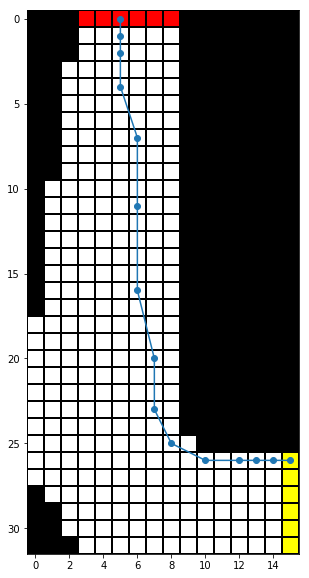

In [147]:
rt.draw_episode(S, A, R)

In [111]:
Q_joakim = np.load(os.path.join(os.getcwd(), 'Q_matrix_Joakim.csv.npy'))

In [98]:
Q_troels = np.load(os.path.join(os.getcwd(), 'Q_matrix_Troels.csv.npy'))

In [25]:
play_episode(agent.Q, rt)

NameError: name 'play_episode' is not defined